In [1]:
import glob
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

from matplotlib.ticker import NullFormatter

from IPython.display import display



In [2]:
exp_group_name = 'batch_experiments_default'
exp_folder = f"./results/{exp_group_name}/"
figs_folder = f"./figs/{exp_group_name}/"

# create the figs folder
!mkdir -p {figs_folder}

exp_paths = glob.glob(f'{exp_folder}/*.csv')
exp_paths


['./results/batch_experiments_default/bentoml-iris_2021-05-04_23-40-01.csv',
 './results/batch_experiments_default/bentoml-pytorch-fashion-mnist_2021-06-22_14-24-31.csv',
 './results/batch_experiments_default/bentoml-keras-toxic-comments_2021-06-22_17-00-22.csv']

In [3]:
def extract_raw_exp_name(v):
    return v.split('/')[-1].split('.')[0]

def get_exp_name(v):
    if 'tfserving-mobilenetv1' in v:
        return 'TFServing MobileNetV1'
    elif 'bentoml-iris' in v:
        return 'BentoML Iris'
    elif 'tfserving-resnetv2' in v:
        return 'TFServing ResNet-v2'
    elif 'bentoml-onnx-resnet50_' in v:
        return 'BentoML ONNX ResNet50-v2'
    elif 'bentoml-pytorch-fashion-mnist' in v:
        return 'PyTorch Fashion MNIST'
    elif 'bentoml-keras-toxic-comments' in v:
        return 'Keras Toxic Comments'
    else:
        return v.split('/')[-1].split('_')[0]

display([get_exp_name(v) for v in exp_paths])
display([extract_raw_exp_name(v) for v in exp_paths])

['BentoML Iris', 'PyTorch Fashion MNIST', 'bentoml-keras-toxic-comments']

['bentoml-iris_2021-05-04_23-40-01',
 'bentoml-pytorch-fashion-mnist_2021-06-22_14-24-31',
 'bentoml-keras-toxic-comments_2021-06-22_17-00-22']

In [4]:
# the experiment path that we will use for developing our plots here
# exp_path = [f for f in exp_paths if 'onnx-resnet50' in f][0]
exp_path = exp_paths[0]
print(exp_path)
exp_name = get_exp_name(exp_path)
print(exp_name)
raw_exp_name = extract_raw_exp_name(exp_path)
print(raw_exp_name)

# processing the csv file to extract info
def post_process(df):
    convert_resp_time_lambda = lambda row: np.array(json.loads(row['response_times_ms'])).astype(np.float)
    df['response_times_ms'] = df.apply(convert_resp_time_lambda, axis=1)
    df['resp_time_avg'] = df.apply(lambda x: np.mean(x['response_times_ms']), axis=1)
    for percentile in [5,50,90,95,99]:
        df[f'resp_time_p{percentile}'] = df.apply(lambda x: np.percentile(x['response_times_ms'], percentile), axis=1)
    df[f'request_count'] = df.apply(lambda x: len(x['response_times_ms']), axis=1)
    return df

df = pd.read_csv(exp_path, index_col=0, parse_dates=True)
df = post_process(df)
df

./results/batch_experiments_default/bentoml-iris_2021-05-04_23-40-01.csv
BentoML Iris
bentoml-iris_2021-05-04_23-40-01


,warmup_req_count,total_req_count,service_name,batch_size,response_times_ms,reqs_failed,reqs_succeeded,resp_time_avg,resp_time_p5,resp_time_p50,resp_time_p90,resp_time_p95,resp_time_p99,request_count
0,200,1000,bentoml-iris,1,"[17.813, 20.513, 16.281, 19.363, 19.701, 24.04...",0,1000,21.469174,16.63695,19.3975,23.0534,26.93015,76.37673,1000
1,200,1000,bentoml-iris,5,"[17.16, 18.468, 17.926000000000002, 18.1279999...",0,1000,19.732239,16.42425,19.3210,22.3797,24.34550,29.49686,1000
2,200,1000,bentoml-iris,10,"[21.032, 20.75, 19.023000000000003, 18.4470000...",0,1000,19.672685,16.24785,19.3145,22.5571,24.22335,28.06594,1000
3,200,1000,bentoml-iris,20,"[17.971, 18.628, 18.724999999999998, 15.484, 2...",0,1000,26.806492,16.95035,20.1440,25.0013,35.16515,245.61540,1000
4,200,1000,bentoml-iris,50,"[39.654, 21.796, 18.21, 21.134, 22.345, 19.834...",0,1000,47.832800,18.96735,35.8120,49.4618,244.07250,247.74500,1000
5,200,1000,bentoml-iris,100,"[37.466, 21.772, 21.668, 37.977, 40.594, 21.28...",0,1000,58.545895,20.77385,38.2710,98.2410,248.16165,256.31234,1000


In [5]:
# prepare for plotting
def save_fig(figname, raw_exp_name):
    if raw_exp_name is not None:
        plt.savefig(figs_folder + f"{raw_exp_name}_{figname}" + ".png", dpi=600)
        plt.savefig(figs_folder + f"{raw_exp_name}_{figname}" + ".pdf")

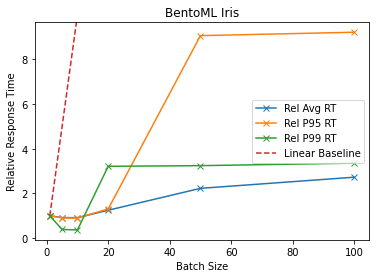

In [6]:
def create_relative_batch_plots(**kwargs):
    df = kwargs.get('df')
    raw_exp_name = kwargs.get('raw_exp_name')

    base_row = df.loc[df['batch_size']==1,:].iloc[0]
    exp_name = kwargs.get('exp_name')

    plt.figure()
    plt.plot(df['batch_size'], df['resp_time_avg']/base_row['resp_time_avg'], label='Rel Avg RT', marker='x')
    plt.plot(df['batch_size'], df['resp_time_p95']/base_row['resp_time_p95'], label='Rel P95 RT', marker='x')
    plt.plot(df['batch_size'], df['resp_time_p99']/base_row['resp_time_p99'], label='Rel P99 RT', marker='x')
    prev_ylim = plt.gca().get_ylim()
    plt.plot(df['batch_size'], df['batch_size'], ls='--', label='Linear Baseline')
    plt.ylim(prev_ylim)
    plt.legend()
    plt.title(exp_name)
    plt.xlabel('Batch Size')
    plt.ylabel('Relative Response Time')

    save_fig('relative_batch_response_time', raw_exp_name)

    return kwargs

_ = create_relative_batch_plots(df=df, exp_name=exp_name, raw_exp_name=raw_exp_name)

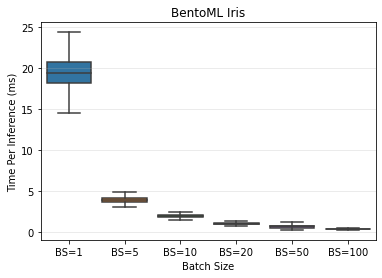

In [7]:
def create_resp_time_hist_plots(**kwargs):
    df = kwargs.get('df')
    raw_exp_name = kwargs.get('raw_exp_name')

    # min_x_plt = (df['resp_time_p5']/df['resp_time_avg']).min()
    # max_x_plt = (df['resp_time_p95']/df['resp_time_avg']).max()
    min_x_plt = (df['resp_time_p5']/df['batch_size']).min()
    max_x_plt = (df['resp_time_p95']/df['batch_size']).max()


    data = []
    batch_sizes = df['batch_size'].unique()
    for batch_size in batch_sizes:
        base_row = df.loc[df['batch_size']==batch_size,:].iloc[0]

        exp_name = kwargs.get('exp_name')
        fig_title = f"{exp_name} (BS={batch_size})"
        rt_hist_bins = kwargs.get('rt_hist_bins', 100)

        # hist_data = base_row['response_times_ms']/base_row['resp_time_avg']
        hist_data = base_row['response_times_ms']/base_row['batch_size']
        gkde = stats.gaussian_kde(dataset=hist_data)

        # for violin plot
        data.append(hist_data)

        # plt.figure()
        # hist, bins, _ = plt.hist(hist_data, bins=rt_hist_bins, range=(min_x_plt, max_x_plt), density=True, alpha=0.6, color='#607c8e')
        # bins_kde = gkde(bins)
        # plt.plot(bins, bins_kde, ls='--', color='k')
        # plt.xlim((min_x_plt,max_x_plt))
        # plt.title(fig_title)
        # plt.grid(alpha=0.75)
        # plt.xlabel('Time Per Prediction (ms)')
        # plt.ylabel('Density')
        # save_fig(f'resp_time_hist_bs{batch_size}', raw_exp_name)

    labels = [f"BS={bs}" for bs in batch_sizes]
    plt.figure()
    sns.boxplot(data=data, showfliers=False)
    plt.gca().set_xticks(np.arange(0, len(labels)))
    plt.gca().set_xticklabels(labels)
    plt.grid(axis='y', alpha=0.3)
    plt.ylabel('Time Per Inference (ms)')
    plt.xlabel('Batch Size')
    plt.title(exp_name)
    save_fig(f'resp_time_boxplot_bs', raw_exp_name)

    return kwargs

_ = create_resp_time_hist_plots(df=df, exp_name=exp_name, raw_exp_name=raw_exp_name)

==================== ./results/batch_experiments_default/bentoml-iris_2021-05-04_23-40-01.csv ====================
[*] Extract Experiment Name
[*] Read CSV
[*] Post Processing
[*] Relative Batch Plots
[*] Relative Response Time Histograms
==================== ./results/batch_experiments_default/bentoml-pytorch-fashion-mnist_2021-06-22_14-24-31.csv ====================
[*] Extract Experiment Name
[*] Read CSV
[*] Post Processing
[*] Relative Batch Plots
[*] Relative Response Time Histograms
==================== ./results/batch_experiments_default/bentoml-keras-toxic-comments_2021-06-22_17-00-22.csv ====================
[*] Extract Experiment Name
[*] Read CSV
[*] Post Processing
[*] Relative Batch Plots
[*] Relative Response Time Histograms


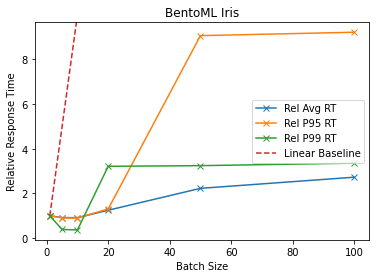

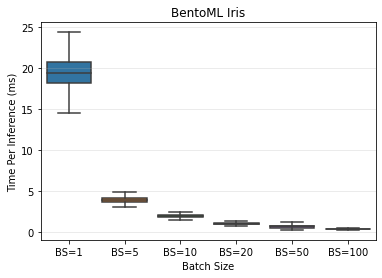

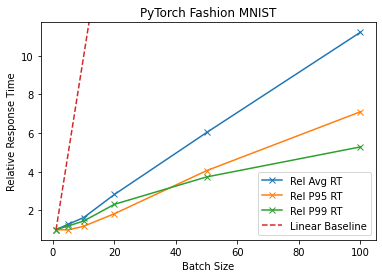

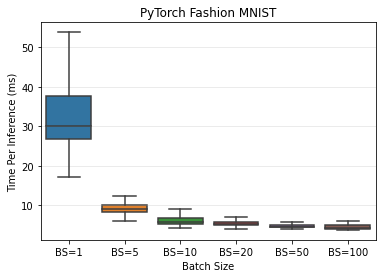

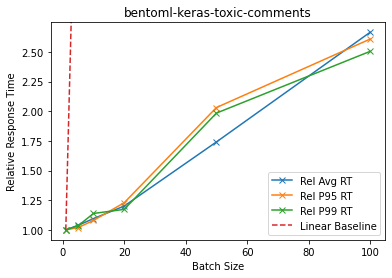

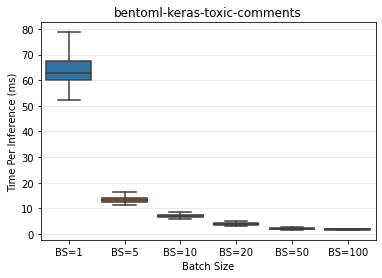

In [8]:
processing_pipeline = [
    ('Extract Experiment Name', lambda vals: {
        'exp_name': get_exp_name(vals['exp_path']),
        'raw_exp_name': extract_raw_exp_name(vals['exp_path']),
    }),
    ('Read CSV', lambda vals: {'df': pd.read_csv(exp_path, index_col=0, parse_dates=True)}),
    ('Post Processing', lambda vals: {'df': post_process(vals['df'])} ),
    ('Relative Batch Plots', lambda vals: create_relative_batch_plots(**vals)),
    ('Relative Response Time Histograms', lambda vals: create_resp_time_hist_plots(**vals)),
]

def process_exp_path(vals, processing_pipeline):
    exp_path = vals['exp_path']
    print('='*20, exp_path, '='*20)

    inter = vals
    for step_name, step_func in processing_pipeline:
        print(f'[*] {step_name}')
        inter_update = step_func(inter)
        inter.update(inter_update)
    return inter


for exp_path in exp_paths:
    vals = {
        'exp_path': exp_path
    }
    process_exp_path(vals, processing_pipeline)

# Variable Config Analysis

In the previous section, we analyzed the performance of the system under different circumistances using the default configuration.
Here, our goal is to analyze the performance under differenet configurations.

In [9]:
exp_group_name = 'batch_experiments_var_cpu'
exp_folder = f"./results/{exp_group_name}/"
figs_folder = f"./figs/{exp_group_name}/"

# create the figs folder
!mkdir -p {figs_folder}

exp_paths = glob.glob(f'{exp_folder}/*.csv')
exp_paths

['./results/batch_experiments_var_cpu/bentoml-pytorch-fashion-mnist_2021-06-16_19-01-54.csv',
 './results/batch_experiments_var_cpu/bentoml-keras-toxic-comments_2021-06-22_18-47-01.csv']

In [11]:
exp_path = exp_paths[0]
print(exp_path)
exp_name = get_exp_name(exp_path)
print(exp_name)
raw_exp_name = extract_raw_exp_name(exp_path)
print(raw_exp_name)

# processing the csv file to extract info (reuse previous post processing)
df = pd.read_csv(exp_path, index_col=0, parse_dates=True)
df = post_process(df)
df

./results/batch_experiments_var_cpu/bentoml-pytorch-fashion-mnist_2021-06-16_19-01-54.csv
PyTorch Fashion MNIST
bentoml-pytorch-fashion-mnist_2021-06-16_19-01-54


,warmup_req_count,total_req_count,service_name,cpu_m,batch_size,response_times_ms,reqs_failed,reqs_succeeded,ram_mb,resp_time_avg,resp_time_p5,resp_time_p50,resp_time_p90,resp_time_p95,resp_time_p99,request_count
0,20,1000,bentoml-pytorch-fashion-mnist,250,1,"[171.59099999999998, 94.87700000000001, 111.41...",0,1000,375,186.753749,23.74520,101.5940,395.5511,502.58700,802.89366,1000
1,20,1000,bentoml-pytorch-fashion-mnist,250,5,"[77.41000000000001, 386.476, 99.292, 191.208, ...",0,1000,375,198.209966,96.42350,187.6705,301.9692,501.30315,800.64929,1000
2,20,1000,bentoml-pytorch-fashion-mnist,250,10,"[259.213, 194.399, 201.982, 191.855, 204.87900...",0,1000,375,246.488985,175.77420,198.5945,381.7998,493.10245,708.60788,1000
3,20,1000,bentoml-pytorch-fashion-mnist,250,20,"[365.238, 290.429, 305.699, 292.507, 294.433, ...",0,1000,375,348.906537,288.14470,301.0310,399.2901,502.06980,792.70916,1000
4,20,1000,bentoml-pytorch-fashion-mnist,250,50,"[945.917, 681.041, 691.025, 700.433, 592.69099...",0,1000,375,662.988300,586.99825,676.9525,712.3202,795.83825,988.92794,1000
5,20,1000,bentoml-pytorch-fashion-mnist,250,100,"[1243.1209999999999, 1185.959, 1116.911, 1185....",0,1000,375,1197.572917,1088.62925,1183.3150,1292.5505,1379.45705,1585.10561,1000
6,20,1000,bentoml-pytorch-fashion-mnist,500,1,"[52.394000000000005, 25.307, 68.23899999999999...",0,1000,750,91.214913,21.75080,73.9025,199.0868,275.16045,306.44355,1000
7,20,1000,bentoml-pytorch-fashion-mnist,500,5,"[264.096, 33.776, 71.647, 95.893, 82.199999999...",0,1000,750,95.229121,32.79065,85.1665,182.2075,208.43555,391.82123,1000
8,20,1000,bentoml-pytorch-fashion-mnist,500,10,"[61.641, 97.236, 91.42, 94.558, 95.295, 103.18...",0,1000,750,119.884027,79.73445,98.4620,181.4975,209.31355,403.41197,1000
9,20,1000,bentoml-pytorch-fashion-mnist,500,20,"[82.577, 185.504, 109.65700000000001, 169.853,...",0,1000,750,168.510478,111.61875,171.4000,201.1208,277.73205,393.36916,1000


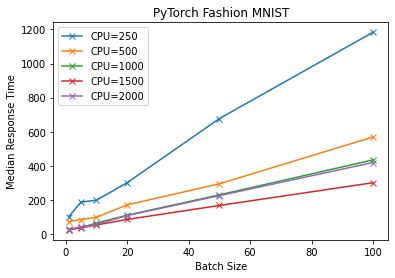

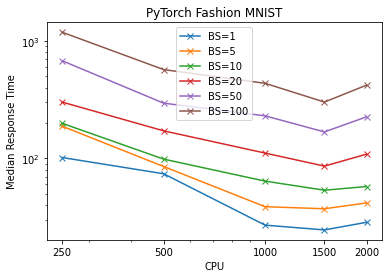

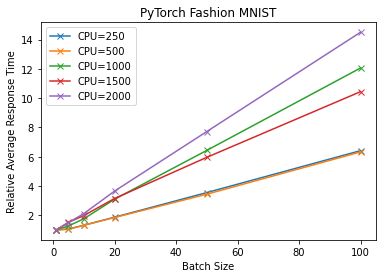

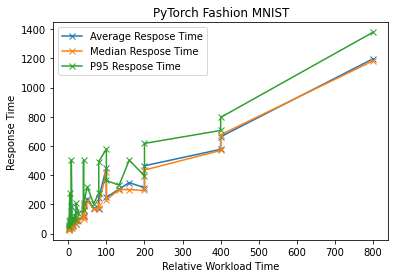

In [12]:
def create_relative_batch_plots_var_cpu(**kwargs):
    df = kwargs.get('df')
    raw_exp_name = kwargs.get('raw_exp_name')
    exp_name = kwargs.get('exp_name')

    plt.figure()
    grouped_df = df.set_index('batch_size').groupby('cpu_m')
    cpu_ms = [d[0] for d in grouped_df['cpu_m'].unique().values]
    # grouped_df['resp_time_avg'].plot()
    grouped_df['resp_time_p50'].plot(marker='x')
    plt.legend([f"CPU={c}" for c in cpu_ms])
    plt.title(exp_name)
    plt.xlabel('Batch Size')
    plt.ylabel('Median Response Time')
    save_fig('median_batch_response_time', raw_exp_name)

    plt.figure()
    grouped_df = df.set_index('cpu_m').groupby('batch_size')
    batch_sizes = [d[0] for d in grouped_df['batch_size'].unique().values]
    # grouped_df['resp_time_avg'].plot()
    grouped_df['resp_time_p50'].plot(loglog=True, marker='x')
    plt.legend([f"BS={c}" for c in batch_sizes])
    plt.title(exp_name)
    plt.xlabel('CPU')
    plt.ylabel('Median Response Time')
    plt.gca().xaxis.set_minor_formatter(NullFormatter())
    plt.xticks(ticks=cpu_ms, labels=[f"{c}" for c in cpu_ms])
    save_fig('median_cpu_response_time', raw_exp_name)

    plt.figure()
    for cpu_m in df['cpu_m'].unique():
        sub_df = df[df['cpu_m']==cpu_m]
        base_row = sub_df.loc[sub_df['batch_size']==1,:].iloc[0]
        plt.plot(sub_df['batch_size'], sub_df['resp_time_avg']/base_row['resp_time_avg'], label=f'CPU={cpu_m}', marker='x')
    plt.legend()
    plt.title(exp_name)
    plt.xlabel('Batch Size')
    plt.ylabel('Relative Average Response Time')
    save_fig('relative_batch_average_response_time', raw_exp_name)

    # plot relative workload (batch size over cpu value)
    plt.figure()
    df['relative_workload_time'] = df['batch_size']/df['cpu_m']
    # normalize the new column
    df['relative_workload_time'] = df['relative_workload_time'] / df['relative_workload_time'].min()
    sorted_workload_df = df.sort_values(by='relative_workload_time')
    plt.plot(sorted_workload_df['relative_workload_time'], sorted_workload_df['resp_time_avg'], label='Average Respose Time', marker='x')
    plt.plot(sorted_workload_df['relative_workload_time'], sorted_workload_df['resp_time_p50'], label='Median Respose Time', marker='x')
    plt.plot(sorted_workload_df['relative_workload_time'], sorted_workload_df['resp_time_p95'], label='P95 Respose Time', marker='x')
    plt.title(exp_name)
    plt.xlabel('Relative Workload Time')
    plt.ylabel('Response Time')
    plt.legend()
    save_fig('relative_workload_time', raw_exp_name)

    return kwargs

_ = create_relative_batch_plots_var_cpu(df=df, exp_name=exp_name, raw_exp_name=raw_exp_name)

==================== ./results/batch_experiments_var_cpu/bentoml-pytorch-fashion-mnist_2021-06-16_19-01-54.csv ====================
[*] Extract Experiment Name
[*] Read CSV
[*] Post Processing
[*] Relative Batch Plots
==================== ./results/batch_experiments_var_cpu/bentoml-keras-toxic-comments_2021-06-22_18-47-01.csv ====================
[*] Extract Experiment Name
[*] Read CSV
[*] Post Processing
[*] Relative Batch Plots


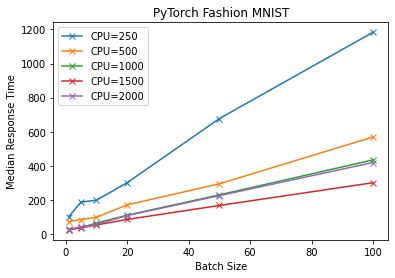

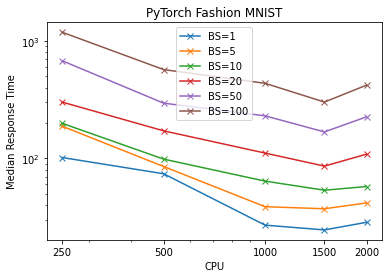

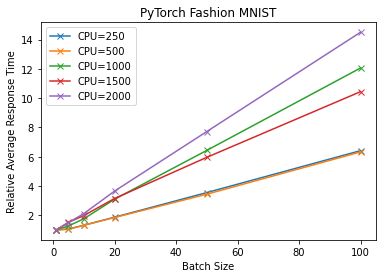

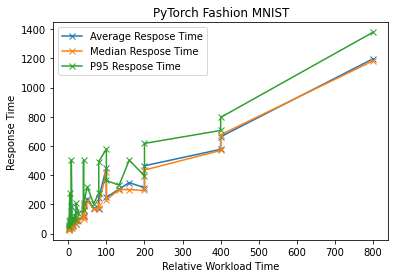

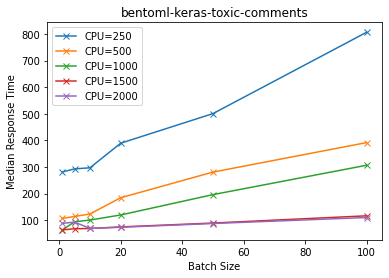

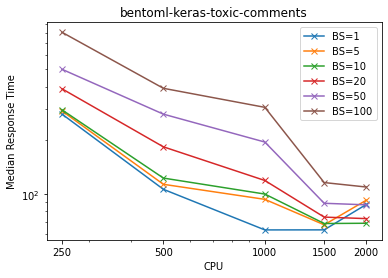

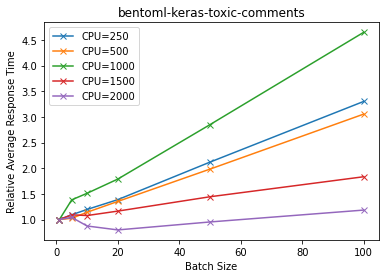

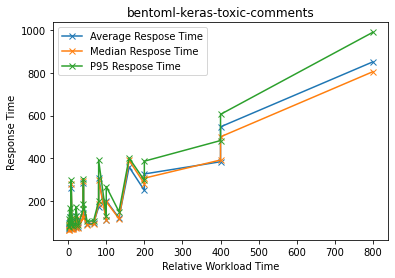

In [13]:
processing_pipeline = [
    ('Extract Experiment Name', lambda vals: {
        'exp_name': get_exp_name(vals['exp_path']),
        'raw_exp_name': extract_raw_exp_name(vals['exp_path']),
    }),
    ('Read CSV', lambda vals: {'df': pd.read_csv(exp_path, index_col=0, parse_dates=True)}),
    ('Post Processing', lambda vals: {'df': post_process(vals['df'])} ),
    # ('Temporary CPU Filter', lambda vals: {'df': vals['df'][vals['df']['cpu_m'] > 250]} ),
    ('Relative Batch Plots', lambda vals: create_relative_batch_plots_var_cpu(**vals)),
    # ('Relative Response Time Histograms', lambda vals: create_resp_time_hist_plots(**vals)),
]


for exp_path in exp_paths:
    vals = {
        'exp_path': exp_path
    }
    process_exp_path(vals, processing_pipeline)